## Imports and Loading Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
df = pd.read_excel('Data Model - Pizza Sales.xlsx')
df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [40]:
df.head(10)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
5,6,2,thai_ckn_l,1,2015-01-01,11:57:40,20.75,20.75,L,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha...",The Thai Chicken Pizza
6,7,3,ital_supr_m,1,2015-01-01,12:12:28,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
7,8,3,prsc_argla_l,1,2015-01-01,12:12:28,20.75,20.75,L,Supreme,"Prosciutto di San Daniele, Arugula, Mozzarella...",The Prosciutto and Arugula Pizza
8,9,4,ital_supr_m,1,2015-01-01,12:16:31,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
9,10,5,ital_supr_m,1,2015-01-01,12:21:30,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza


In [3]:
len(df)

48620

In [4]:
df.isna().sum()

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [5]:
df.dtypes

order_details_id              int64
order_id                      int64
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

In [6]:
min(df['order_date']), max(df['order_date'])

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00'))

### Exploring Daily Sales as a Timeseries

In [7]:
# Sum total sales, grouped by day.
by_days = df.groupby(by = 'order_date')['total_price'].sum()

In [8]:
by_days

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
               ...   
2015-12-27    1419.00
2015-12-28    1637.20
2015-12-29    1353.25
2015-12-30    1337.80
2015-12-31    2916.00
Name: total_price, Length: 358, dtype: float64

In [9]:
# Check to see if any days of data are missing
months = ['2015-01', '2015-02','2015-03', '2015-04', '2015-05', '2015-06', '2015-07','2015-08','2015-09','2015-10', '2015-11','2015-12']

for month in months:
    print(month, len(by_days.loc[month]))

2015-01 31
2015-02 28
2015-03 31
2015-04 30
2015-05 31
2015-06 30
2015-07 31
2015-08 31
2015-09 28
2015-10 27
2015-11 30
2015-12 30


In [10]:
# For example, September 24 is missing
check_dates = df[['order_date']]
check_dates.set_index('order_date', inplace = True)
try:
    check_dates.loc['2015-09-24']
except: 
    print('The date does not exist in the time series')

The date does not exist in the time series


We've identified that some days are missing from some months. We will address this by generating a new index of a complete date range and interpolating the data for the missing days.

In [11]:
# Identify min and max dates
min_date = by_days.index.min()
max_date = by_days.index.max()

# Generate complete date range
complete_date_range = pd.date_range(min_date, max_date)
len(complete_date_range), len(by_days)

(365, 358)

Apparently only seven days of the year are missing. Let's investigate which ones.

In [12]:
# Convert DataFrame index to a Pandas DatetimeIndex if it isn't already
by_days.index = pd.to_datetime(by_days.index)

# Extract the index (dates) from your DataFrame into a separate variable
existing_dates = by_days.index

# Identify missing dates by comparing complete_date_range and existing_dates
missing_dates = complete_date_range.difference(existing_dates)

# Convert to list, if necessary
missing_dates_list = missing_dates.tolist()
missing_dates_list

[Timestamp('2015-09-24 00:00:00'),
 Timestamp('2015-09-25 00:00:00'),
 Timestamp('2015-10-05 00:00:00'),
 Timestamp('2015-10-12 00:00:00'),
 Timestamp('2015-10-19 00:00:00'),
 Timestamp('2015-10-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00')]

In [13]:
# Add missing dates with NaN values
for missing_date in missing_dates:
    by_days[missing_date] = np.nan

by_days.sort_index(inplace=True)

# Interpolate missing values using simple averaging of neighboring days
by_days.interpolate(method='time', inplace=True)

len(by_days)

365

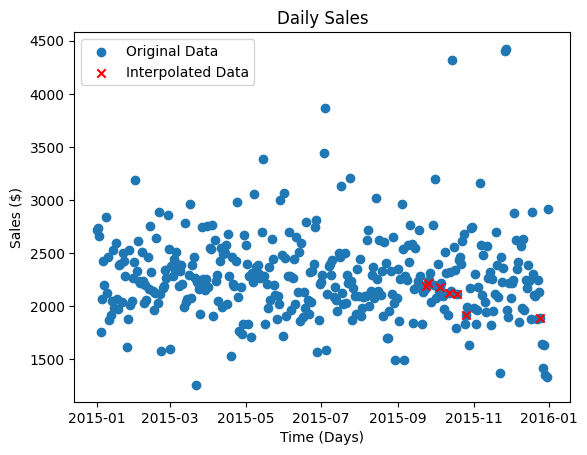

In [38]:
# View the interpolated points with the rest of the native data points
plt.scatter(x = by_days.index, y = by_days, label = 'Original Data')
plt.scatter(x = by_days.loc[missing_dates_list].index, y = by_days.loc[missing_dates_list], c = 'r', marker = 'x', label = 'Interpolated Data')

plt.title('Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.legend()

plt.show()

In [14]:
# Pickle cleaned up dataframe and save for later
by_days.to_pickle('sales_by_day.pkl')